<a href="https://colab.research.google.com/github/leihuang/scrapbook/blob/master/ConsortiumSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

This notebook simulates and compares the following two architectures: 

* One with **domain-specific transformation** layers (top; referred to as "*specific*" hereafter)
* One with a **common transformation** layer (bottom; referred to as "*common*" hereafter)

In the "specific" case, features ($x_1$ and $x_2$) are sent to transformation layer $T_1$ if $d=1$ and are sent to transformation layer $T_2$ if $d=2$. Then another layer (which we tentatively call "classification layer") to output a binary classification result. 

In the "common" case, features are sent to a common transformation layer followed by a "classification layer". 

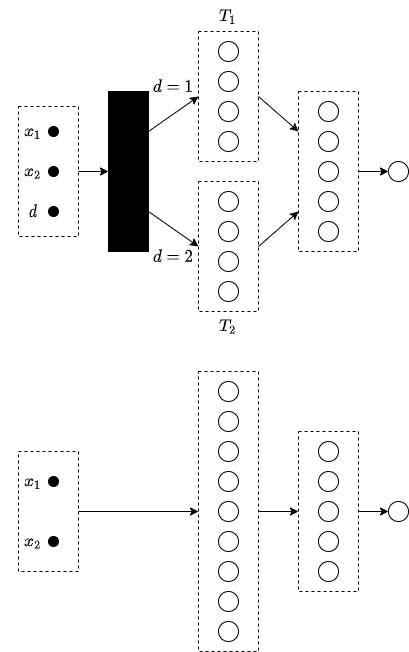

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

plt.style.use('ggplot')

In [2]:
N = 500  # (half) the sample size
EPOCHS = 2000

In [3]:
class SpecificModel(nn.Module):
    def __init__(self):
        super(SpecificModel, self).__init__()
        self.transformation1 = nn.Linear(2, 10)
        self.transformation2 = nn.Linear(2, 10)
        self.common_layer = nn.Linear(10, 1)
        
    def forward(self, x):
        d = x[:, 2]
        x = x[:, :2]
        idxs1 = d==1
        idxs2 = d==2
        x1 = x[idxs1]
        x2 = x[idxs2]
        x1 = F.relu(self.transformation1(x1))
        x2 = F.relu(self.transformation2(x2))
        x1 = self.common_layer(x1)
        x2 = self.common_layer(x2)
        logits = torch.zeros(2*N, 1)
        logits[idxs1] = x1
        logits[idxs2] = x2
        return torch.sigmoid(logits)[:,0]

In [4]:
class CommonModel(nn.Module):
    def __init__(self):
        super(CommonModel, self).__init__()
        self.transformation = nn.Linear(2, 18)
        self.common_layer = nn.Linear(18, 1)
        
    def forward(self, x):
        x = x[:, :2]
        x = F.relu(self.transformation(x))
        x = self.common_layer(x)
        return torch.sigmoid(x)[:,0]

In [5]:
class IndependentModel(nn.Module):
    def __init__(self):
        super(IndependentModel, self).__init__()
        self.transformation = nn.Linear(2, 9)
        self.common_layer = nn.Linear(9, 1)
        
    def forward(self, x):
        x = x[:, :2]
        x = F.relu(self.transformation(x))
        x = self.common_layer(x)
        return torch.sigmoid(x)[:,0]

In [6]:
smodel = SpecificModel()
soptimizer = torch.optim.Adam(smodel.parameters(), lr=0.001)

cmodel = CommonModel()
coptimizer = torch.optim.Adam(cmodel.parameters(), lr=0.001)

imodel1 = IndependentModel()
ioptimizer1 = torch.optim.Adam(imodel1.parameters(), lr=0.001)
imodel2 = IndependentModel()
ioptimizer2 = torch.optim.Adam(imodel2.parameters(), lr=0.001)

loss_fn = nn.BCELoss()

In [7]:
def get_parameter_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

get_parameter_count(smodel), get_parameter_count(cmodel),\
get_parameter_count(imodel1), get_parameter_count(imodel2)

(71, 73, 37, 37)

# Make synthetic data

For domain 1 ($d=1$), $p(y=1 | x) = \text{Logistic}(x_1-x_2+0.5)$, where $\displaystyle \text{Logistic}(z) = \frac{1}{1+e^{-z}}$. 

For domain 2 ($d=2$), $p(y=1 | x) = \text{Logistic}(-x_1+x_2-0.5)$.

In [8]:
X = np.random.randn(2*N, 2)
d = np.reshape([1]*N+[2]*N, (2*N,1))
X = np.hstack((X, d))
y1 = (np.random.rand(N)<1/(1+np.exp(-(np.dot(X[:N,:2], [1,-1])+0.5)))).astype('int')
y2 = (np.random.rand(N)<1/(1+np.exp(-(np.dot(X[N:,:2], [-1,1])-0.5)))).astype('int')
y = np.concatenate((y1, y2))

X = Variable(torch.from_numpy(X)).float()
y = Variable(torch.from_numpy(y)).float()
X1, X2 = X[:N], X[N:]
y1, y2 = y[:N], y[N:]

In [9]:
def train_and_validate(model, optimizer, loss_fn, X_train, y_train, X_test, y_test):
    """
    """
    losss = []
    accus = []

    for epoch in tqdm.trange(EPOCHS):
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        losss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            y_pred = model(X_test)
            idxs1 = X_test[:,2]==1
            idxs2 = X_test[:,2]==2
            bools1 = ((y_pred[idxs1]>0.5).long() == y_test[idxs1]).type(torch.FloatTensor)
            bools2 = ((y_pred[idxs2]>0.5).long() == y_test[idxs2]).type(torch.FloatTensor)
            accus.append([bools1.mean(), bools2.mean()])

    return np.array(losss), np.array(accus)


In [10]:
slosss, saccus = train_and_validate(smodel, soptimizer, loss_fn, X, y, X, y)
closss, caccus = train_and_validate(cmodel, coptimizer, loss_fn, X, y, X, y)

100%|██████████| 2000/2000 [00:02<00:00, 915.67it/s]


In [11]:
ilosss1, iaccus1 = train_and_validate(imodel1, ioptimizer1, loss_fn, X1, y1, X, y)
ilosss2, iaccus2 = train_and_validate(imodel2, ioptimizer2, loss_fn, X2, y2, X, y)

100%|██████████| 2000/2000 [00:02<00:00, 967.40it/s]


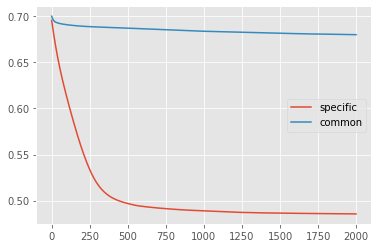

In [12]:
fig, ax = plt.subplots()
ax.plot(slosss, label='specific')
ax.plot(closss, label='common')
ax.legend()
plt.show()

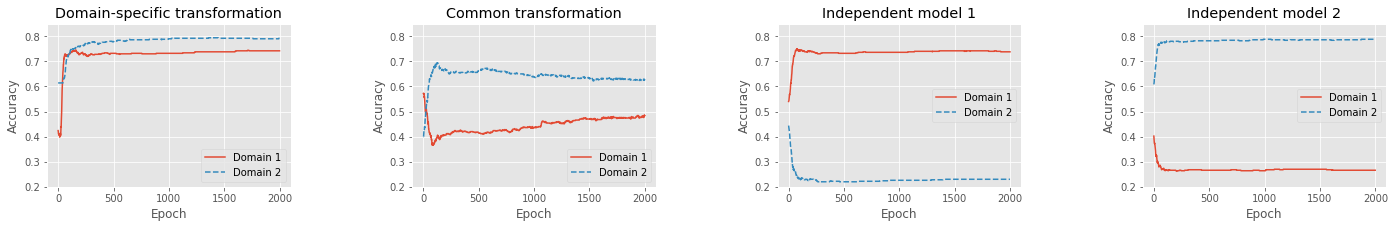

In [16]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(24,3))
ax1.plot(saccus[:,0], '-', label='Domain 1')
ax1.plot(saccus[:,1], '--', label='Domain 2')
ax1.set_title('Domain-specific transformation')

ax2.plot(caccus[:,0], '-', label='Domain 1')
ax2.plot(caccus[:,1], '--', label='Domain 2')
ax2.set_title('Common transformation')

ax3.plot(iaccus1[:,0], '-', label='Domain 1')
ax3.plot(iaccus1[:,1], '--', label='Domain 2')
ax3.set_title('Independent model 1')

ax4.plot(iaccus2[:,0], '-', label='Domain 1')
ax4.plot(iaccus2[:,1], '--', label='Domain 2')
ax4.set_title('Independent model 2')

for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.set_ylim(0.2, 0.85)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    if i < 2:
        ax.legend(loc='lower right')
    else:
        ax.legend(loc='center right')

plt.subplots_adjust(wspace=0.5)
ax.legend()
plt.show()